In [1]:
%pylab inline
import pylab

Populating the interactive namespace from numpy and matplotlib


In [2]:
import nengo
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry
import numpy as np
import pylab
import pandas as pd
import seaborn as sns
import itertools
import scipy
import string
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.ensemble import response_curves, tuning_curves

import os
import sys

%run ../UTC.py

## Gap procedure

Note: if you want to simulate data in these gap procedures more quickly, you can rescale all time variables (target time, gap onset, gap duration). The network is timescale-invariant, and therefore the results will be identical, but just rescaled in time (provided you simulate in Direct mode; neurons themselves aren't timescale invariant). 

### Buhusi & Meck (2009) 'Relativity Theory and Time Perception: Single or Multiple Clocks?'

In the original 'tri-peak' task, rats learned to press different levers for different Fixed Intervals (10, 30, 90s). Within individual probe and gap trials, rats responded around 10s for the first lever, around 30s for the second, and around 90s for the third. That is, they switched from lever to lever over the course of individual trials. We do assume that during the trial, independent timing networks run simultaneously for pressing different levers, at different speeds. Here, for simplicity, we simulate a seperate model for each of the levers. 

In [3]:
# set parameters
target_list = np.array([10, 30, 90])
gap_duration_list = np.array([1, 3, 10, 30])
gap_start = 15.

# How to get data? simulate, load_raw
get_dat_method = 'load_raw'

def stimulus_function(t):
    return 0

# generate vocabulary, with SSP's, representing signal loudness
vocab = spa.Vocabulary(64)
vocab.populate('T')

In [4]:
%%capture

if get_dat_method == 'simulate':
    for target, gap_duration in itertools.product(target_list, gap_duration_list):
        LMU_timing().run(task_type='gap_procedure',
                         direct_mode=True,
                         dimensions=2,
                         base_theta=target,
                         effective_theta=target,
                         gap_start=gap_start,
                         gap_duration=gap_duration,
                         stimulus_function=stimulus_function,
                         vocab=vocab,
                         full_output=False,
                         data_dir='buhusi_meck_2009')

In [5]:
gap_data = pytry.read('buhusi_meck_2009')
gap_dt = pd.DataFrame(gap_data)

In [6]:
# Get data
threshold = gap_dt['threshold'].values[0]

# Short target time (10s)
state_input_short = []
state_short = []
for gap_duration in gap_duration_list:
    conditions = (gap_dt['effective_theta']==target_list[0]) & (gap_dt['gap_duration']==gap_duration)
    state_input_short.append(gap_dt[conditions]['state'].values[0])
    state_short.append(gap_dt[conditions]['x'].values[0])
    
# Middle target time (30s)
state_input_middle = []
state_middle = []
for gap_duration in gap_duration_list:
    conditions = (gap_dt['effective_theta']==target_list[1]) & (gap_dt['gap_duration']==gap_duration)
    state_input_middle.append(gap_dt[conditions]['state'].values[0])
    state_middle.append(gap_dt[conditions]['x'].values[0])
    
# long target time (90s)
state_input_long = []
state_long = []
for gap_duration in gap_duration_list:
    conditions = (gap_dt['effective_theta']==target_list[2]) & (gap_dt['gap_duration']==gap_duration)
    state_input_long.append(gap_dt[conditions]['state'].values[0])
    state_long.append(gap_dt[conditions]['x'].values[0])

In [7]:
peaks_short_empirical = np.array([11.71875, 
                                  29.117647058823508, 
                                  38.18181818181819, 
                                  56.41791044776119])

peaks_middle_empirical = np.array([32.343749999999986, 
                                   34.411764705882376, 
                                   53.181818181818244, 
                                   77.01492537313436])


peaks_long_empirical = np.array([93.75, 
                                 93.97058823529412, 
                                 100.00000000000006, 
                                 134.77611940298493])


In [8]:
# get peak times and peak shifts (as a proportion of 'reset')
# Short
peaks_short = []
peak_shifts_short = []
peak_shifts_short_empirical = []
for i in range(0, len(gap_duration_list)):    
    # for shortest duration, get second peak 
    crossing = np.where(state_short[i][:,0] > threshold)[0]
    diff = np.diff(crossing)
    temp = (crossing[np.where(diff != 1)[0]] + np.max(diff)) / 1000
    if len(temp) == 0: # if there's only one threshold crossing, there's no peak shift
        temp = 10.
    else:
        temp = temp[0]
    peaks_short.append(temp)
    peak_shifts_short.append((temp - target_list[0]) / (gap_start + gap_duration_list[i]))
    peak_shifts_short_empirical.append((peaks_short_empirical[i] - target_list[0])
                                       / ((gap_start + gap_duration_list[i])))

peaks_short = np.asarray(peaks_short)
peak_shifts_short = np.asarray(peak_shifts_short)
peak_shifts_short_empirical = np.asarray(peak_shifts_short_empirical)

# Middle
peaks_middle = []
peak_shifts_middle = []
peak_shifts_middle_empirical = []
for i in range(0, len(gap_duration_list)):
    temp = np.where(state_middle[i][:,0] > threshold)[0][0] / 1000
    peaks_middle.append(temp)
    peak_shifts_middle.append((temp - target_list[1]) / (gap_start + gap_duration_list[i]))
    peak_shifts_middle_empirical.append((peaks_middle_empirical[i] - target_list[1])
                                       / ((gap_start + gap_duration_list[i])))

peaks_middle = np.asarray(peaks_middle)
peak_shifts_middle = np.asarray(peak_shifts_middle)
peak_shifts_middle_empirical = np.asarray(peak_shifts_middle_empirical)

# Long
peaks_long = []
peak_shifts_long = []
peak_shifts_long_empirical = []
for i in range(0, len(gap_duration_list)):
    temp = np.where(state_long[i][:,0] > threshold)[0][0] / 1000
    peaks_long.append(temp)
    peak_shifts_long.append((temp - target_list[2]) / (gap_start + gap_duration_list[i]))
    peak_shifts_long_empirical.append((peaks_long_empirical[i] - target_list[2])
                                       / ((gap_start + gap_duration_list[i])))
    
peaks_long = np.asarray(peaks_long)
peak_shifts_long = np.asarray(peak_shifts_long)
peak_shifts_long_empirical = np.asarray(peak_shifts_long_empirical)
    

In [9]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



Text(0, 0.5, 'Resetting proportion')

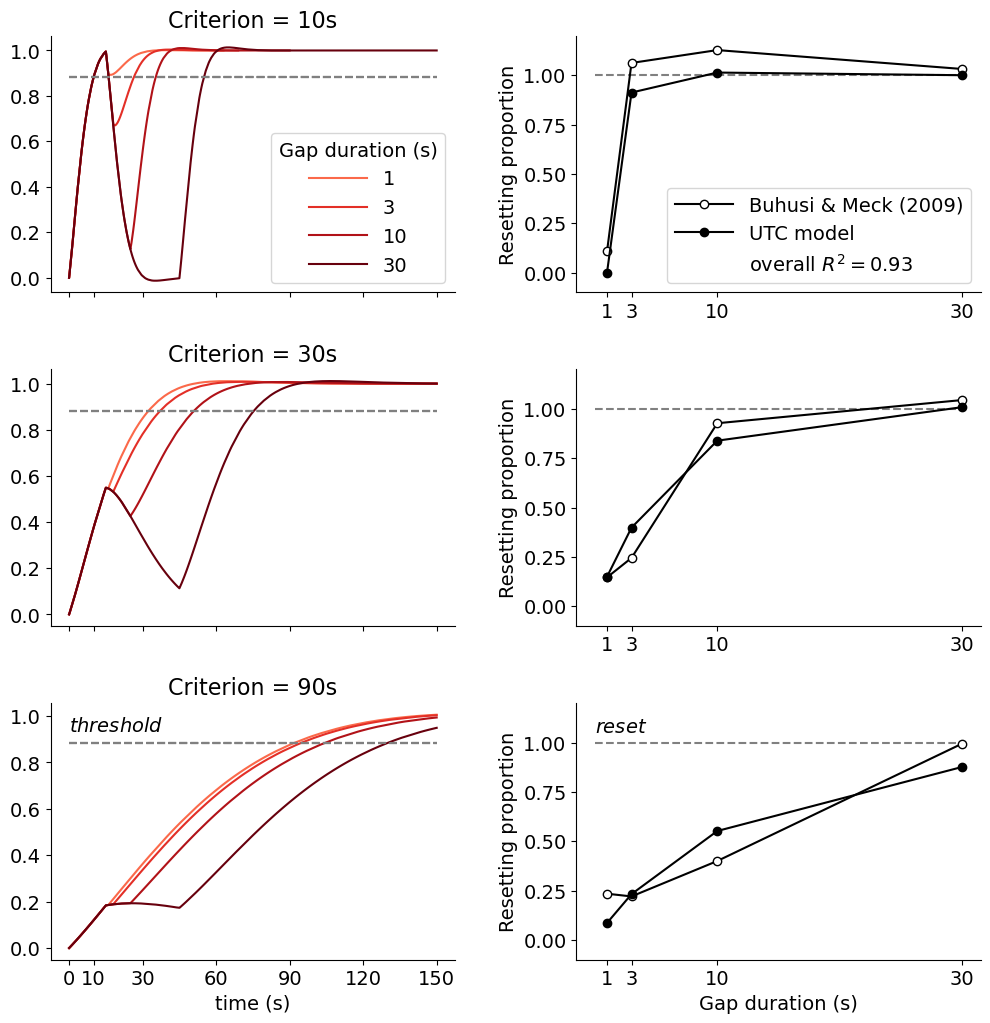

In [10]:
fig = plt.figure(constrained_layout=False, figsize=(12, 12))
gs = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.3)

ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

colors = plt.cm.Reds(np.linspace(0.5, 1, len(gap_duration_list)))
trange = np.arange(0, len(state_long[3][:150000,0])/1000, 0.001)

for i in range(0, len(gap_duration_list)):
    # Short
    trange = np.arange(0, len(state_short[i][:150000,0])/1000, 0.001)
    ax1.plot(trange, state_short[i][:150000, 0],
                 color=colors[i], label=str(gap_duration_list[i]))
    ax1.hlines(y=gap_dt['threshold'].values[0], xmin=0, xmax=150,
                   color='grey', ls='dashed')

    # Middle
    trange = np.arange(0, len(state_middle[i][:150000,0])/1000, 0.001)
    ax3.plot(trange, state_middle[i][:150000, 0],
                 color=colors[i], label=str(gap_duration_list[i]))
    ax3.hlines(y=gap_dt['threshold'].values[0], xmin=0, xmax=150,
                   color='grey', ls='dashed')
    
    # Long
    trange = np.arange(0, len(state_long[i][:150000,0])/1000, 0.001)
    ax5.plot(trange, state_long[i][:150000, 0],
                 color=colors[i], label=str(gap_duration_list[i]))
    ax5.hlines(y=gap_dt['threshold'].values[0], xmin=0, xmax=150,
                   color='grey', ls='dashed')

    

# Short fit
ax2.hlines(y=1., xmin=0, xmax=30, 
         color='grey', ls='dashed')
ax2.plot(gap_duration_list,
         peak_shifts_short_empirical,
         mfc='white', color='black', marker='o',
         label='Buhusi & Meck (2009)')
ax2.plot(gap_duration_list,
         peak_shifts_short,
         mfc='black', color='black', marker='o',
         label='UTC model')
ax2.set_xticks([1, 3, 10, 30])
ax2.set_ylim([-0.1, 1.2])

# Overall R squared for all datapoints
overall_r2 = r2_score(np.concatenate([peak_shifts_short_empirical,
                                      peak_shifts_middle_empirical,
                                      peak_shifts_long_empirical]), 
                      np.concatenate([peak_shifts_short,
                                      peak_shifts_middle,
                                      peak_shifts_long]))
ax2.plot([], [], ' ', label='overall $R^2 = {:.2f}$'.format(overall_r2))
ax2.legend(fontsize=14, handlelength=3,
             loc='lower right')
# Middle fit
ax4.hlines(y=1., xmin=0, xmax=30, 
         color='grey', ls='dashed')
ax4.plot(gap_duration_list,
         peak_shifts_middle_empirical,
         mfc='white', color='black', marker='o')
ax4.plot(gap_duration_list,
         peak_shifts_middle,
         mfc='black', color='black', marker='o')
ax4.set_xticks([1, 3, 10, 30])
ax4.set_ylim([-0.1, 1.2])


# Long fit
ax6.hlines(y=1., xmin=0, xmax=30, 
         color='grey', ls='dashed')
ax6.plot(gap_duration_list,
         peak_shifts_long_empirical,
         mfc='white', color='black', marker='o')
ax6.plot(gap_duration_list,
         peak_shifts_long,
         mfc='black', color='black', marker='o')
ax6.set_xticks([1, 3, 10, 30])
ax6.set_ylim([-0.1, 1.2])
ax6.text(0, 1.05, r'$\it{reset}$', ha='left')

# Setting legends, labels and titles
ax5.set_xlabel('time (s)')
ax5.text(0, gap_dt['threshold'].values[0] + 0.05, 
         r'$\it{threshold}$', ha='left')
ax6.set_xlabel('Gap duration (s)')

ax1.legend(title='Gap duration (s)')
ax1.set_title('Criterion = 10s', size=16)
ax1.set_xticks([0, 10, 30, 60, 90, 120, 150])
ax1.set_xticklabels([])
ax2.set_ylabel('Resetting proportion')
ax3.set_title('Criterion = 30s', size=16)
ax3.set_xticks([0, 10, 30, 60, 90, 120, 150])
ax3.set_xticklabels([])
ax4.set_ylabel('Resetting proportion')
ax5.set_title('Criterion = 90s', size=16)
ax5.set_xticks([0, 10, 30, 60, 90, 120, 150])
ax6.set_ylabel('Resetting proportion')

#plt.savefig('buhusi_meck2009_modelfit.png', bbox_inches='tight', dpi=600)
#fig.savefig('buhusi_meck2009_modelfit.tiff', dpi=1000, bbox_inches='tight')

(-0.27, 1.27, -0.27, 1.27)

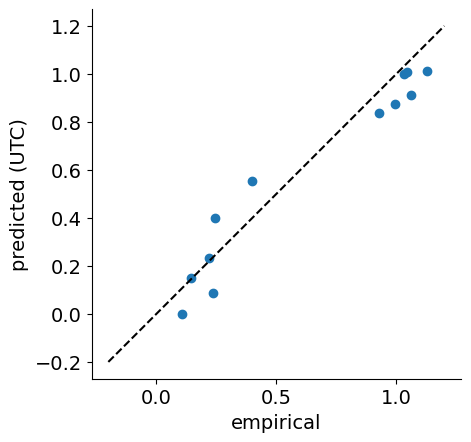

In [11]:
fig, ax = plt.subplots(1, 1)

ax.scatter(np.concatenate([peak_shifts_short_empirical,
                        peak_shifts_middle_empirical,
                        peak_shifts_long_empirical]),
          np.concatenate([peak_shifts_short,
                         peak_shifts_middle,
                         peak_shifts_long]))
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])
ax.plot([-0.2, 1.2], [-0.2, 1.2], color='black', ls='--')

ax.set_xlabel('empirical')
ax.set_ylabel('predicted (UTC)')
plt.axis('square')

### Buhusi (2012) 'Time-Sharing in Rats: Effect of Distracter Intensity and Discriminability'

In [12]:
def stevens(k, i, m):
    return k * i ** m

In [13]:
def power(s, e):
    x = np.fft.ifft(np.fft.fft(s.v) ** e).real
    return spa.SemanticPointer(data=x)

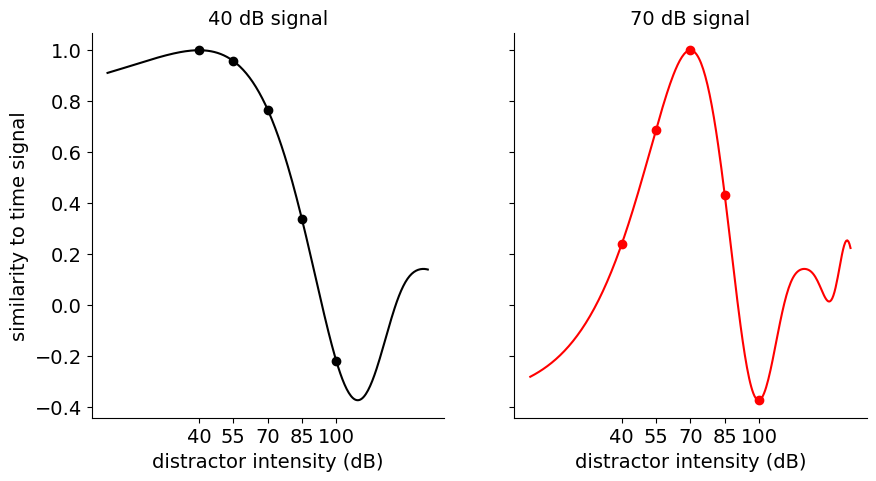

In [14]:
vocab = spa.Vocabulary(64, pointer_gen=np.random.RandomState(4), 
                        max_similarity=0.01)
vocab.populate('T')

k = 2.5 # scaling factor
m = 0.1 # loudness exponent (see Pardo-Vazquez et al. (2019) exponent (lambda))

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

axes[0].set_xlabel('distractor intensity (dB)')
axes[0].set_ylabel('similarity to time signal')
axes[0].set_xticks(np.linspace(40, 100, 5))
axes[0].set_title('40 dB signal')
db_base = 40

for db in np.linspace(40, 100, 5):
    # db to intensity 
    i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
    i = 10 ** (db/10) * 1e-12 

    # intensity to subjective scale
    s_base = stevens(k, i_base, m)
    s = stevens(k, i, m)

    # subjective scale to Spatial semantic pointer X^s
    v = vocab['T'].unitary().v
    fv = np.fft.rfft(v)
    fv[0] = abs(fv[0])
    if len(v) % 2 == 0:
        fv[-1] = abs(fv[-1])
    
    pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))
    
    T = power(pos_v, s_base) # timing signal
    D = power(pos_v, s) # distractor
    axes[0].scatter(db, spa.similarity(T.normalized().v, D.normalized().v, normalize=True), color='black')

db_list = np.linspace(0, 140, 301)
sim_list = list()
for db in db_list:
    # db to intensity 
    i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
    i = 10 ** (db/10) * 1e-12 
    
    # intensity to subjective scale
    s_base = stevens(k, i_base, m)
    s = stevens(k, i, m)
    
    # subjective scale to Spatial semantic pointer X^s
    v = vocab['T'].unitary().v
    fv = np.fft.rfft(v)
    fv[0] = abs(fv[0])
    if len(v) % 2 == 0:
        fv[-1] = abs(fv[-1])
    
    pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))
    
    T = power(pos_v, s_base) # timing signal
    D = power(pos_v, s) # distractor
    sim_list.append(spa.similarity(T.normalized().v, D.normalized().v, normalize=True))

axes[0].plot(db_list, sim_list, color='black')
    
# 70db distractor
axes[1].set_xlabel('distractor intensity (dB)')
#axes[1].set_ylabel('similarity to time signal')
axes[1].set_xticks(np.linspace(40, 100, 5))
axes[1].set_title('70 dB signal')
k = 5
db_base = 70
for db in np.linspace(40, 100, 5):
    # db to intensity 
    i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
    i = 10 ** (db/10) * 1e-12 
    
    # intensity to subjective scale
    s_base = stevens(k, i_base, m)
    s = stevens(k, i, m)
    
    # subjective scale to Spatial semantic pointer X^s
    v = vocab['T'].unitary().v
    fv = np.fft.rfft(v)
    fv[0] = abs(fv[0])
    if len(v) % 2 == 0:
        fv[-1] = abs(fv[-1])
    
    pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))
    
    T = power(pos_v, s_base) # timing signal
    D = power(pos_v, s) # distractor
    axes[1].scatter(db, spa.similarity(T.normalized().v, D.normalized().v, normalize=True), 
                    color='red')

sim_list = list()
for db in db_list:
    # db to intensity 
    i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
    i = 10 ** (db/10) * 1e-12 
    
    # intensity to subjective scale
    s_base = stevens(k, i_base, m)
    s = stevens(k, i, m)
    
    # subjective scale to Spatial semantic pointer X^s
    v = vocab['T'].unitary().v
    fv = np.fft.rfft(v)
    fv[0] = abs(fv[0])
    if len(v) % 2 == 0:
        fv[-1] = abs(fv[-1])
    
    pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))
    
    T = power(pos_v, s_base) # timing signal
    D = power(pos_v, s) # distractor
    sim_list.append(spa.similarity(T.normalized().v, D.normalized().v, normalize=True))

axes[1].plot(db_list, sim_list, color='red')

#### Experiment 1: 40 dB background

In [15]:
# set parameters
target = 31.1
gap_onset = 20.
gap_duration = 5.
db_base = 40
D = 64
k = 2.5 # scaling factor

def stimulus_function(t):
    return 0


In [16]:
%%capture
db_base = 40

if get_dat_method == 'simulate':
    for db in np.linspace(40, 100, 5):
        vocab = spa.Vocabulary(D, pointer_gen=np.random.RandomState(4), 
                            max_similarity=0.01)
        vocab.populate('X')

        # db to intensity 
        i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
        i = 10 ** (db/10) * 1e-12 

        # intensity to subjective scale
        s_base = stevens(k, i_base, m)
        s = stevens(k, i, m)

        # subjective scale to Spatial semantic pointer X^s
        v = vocab['X'].unitary().v
        fv = np.fft.rfft(v)
        fv[0] = abs(fv[0])
        if len(v) % 2 == 0:
            fv[-1] = abs(fv[-1])

        pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))

        timing_signal = power(pos_v, s_base) # timing signal
        distractor_signal = power(pos_v, s) # distractor

        vocab.add('T', timing_signal.normalized().v)
        vocab.add('D', distractor_signal.normalized().v)

        UTC().run(task_type='distractor_procedure',
                         direct_mode=True,
                         dimensions=2,
                         D=D,
                         base_theta=target,
                         effective_theta=target,
                         gap_start=gap_onset,
                         gap_duration=gap_duration,
                         vocab=vocab,
                         stimulus_function=stimulus_function,
                         trial_duration=60.,
                         full_output=False,
                         ID = db,
                         data_dir='buhusi_2012_1')




In [17]:
gap_data = pytry.read('buhusi_2012_1')

In [18]:
gap_dt = pd.DataFrame(gap_data)

In [19]:
state_input = []
state = []
for db in np.linspace(40, 100, 5):
    conditions = (gap_dt['ID']==db)
    state_input.append(np.squeeze(gap_dt[conditions]['state'].values[0]))
    state.append(np.squeeze(gap_dt[conditions]['x'].values[0][:, 1]))


In [20]:
# get peak times
peaks1 = []

for i in range(5):
    # duration (fixed onset)
    temp = np.where(state[i] > gap_dt['threshold'].values[0])[0][0]
    peaks1.append(temp/1000)
    

#### Experiment 2: 70 dB background

In [21]:
# set parameters

# in the experiments, rats slightly overestimated on the base duration
# so we take the peak time in the no-distractor condition and have our model
# produce that target duration
target = 31.1 
gap_onset = 20.
gap_duration = 5.
db_base = 70
D = 64
k = 5 # scaling factor (only free parameter that differs between experiments)
m = 0.1 # loudness exponent

def stimulus_function(t):
    return 0

get_dat_method = 'load_raw'

In [22]:
%%capture

if get_dat_method == 'simulate':
    for db in np.linspace(40, 100, 5):
        vocab = spa.Vocabulary(D, pointer_gen=np.random.RandomState(4), 
                            max_similarity=0.01)
        vocab.populate('X')

        # db to intensity 
        i_base = 10 ** (db_base/10) * 1e-12 # I = 10 ^ (dB/10) * 10e-12
        i = 10 ** (db/10) * 1e-12 

        # intensity to subjective scale
        s_base = stevens(k, i_base, m)
        s = stevens(k, i, m)

        # subjective scale to Spatial semantic pointer X^s
        v = vocab['X'].unitary().v
        fv = np.fft.rfft(v)
        fv[0] = abs(fv[0])
        if len(v) % 2 == 0:
            fv[-1] = abs(fv[-1])

        pos_v = spa.SemanticPointer(np.fft.irfft(fv, len(v)))

        timing_signal = power(pos_v, s_base) # timing signal
        distractor_signal = power(pos_v, s) # distractor

        vocab.add('T', timing_signal.normalized().v)
        vocab.add('D', distractor_signal.normalized().v)

        UTC().run(task_type='distractor_procedure',
                         direct_mode=True,
                         dimensions=2,
                         D=D,
                         base_theta=target,
                         effective_theta=target,
                         gap_start=gap_onset,
                         gap_duration=gap_duration,
                         vocab=vocab,
                         stimulus_function=stimulus_function,
                         trial_duration=60.,
                         full_output=False,
                         ID = db,
                         data_dir='buhusi_2012_2')
 

In [23]:
gap_data = pytry.read('buhusi_2012_2')
gap_dt = pd.DataFrame(gap_data)

In [24]:
state_input = []
state = []
for db in np.linspace(40, 100, 5):
    conditions = (gap_dt['ID']==db)
    state_input.append(np.squeeze(gap_dt[conditions]['state'].values[0]))
    state.append(np.squeeze(gap_dt[conditions]['x'].values[0][:, 1]))


In [25]:
# get peak times
peaks2 = []

for i in range(5):
    # duration (fixed onset)
    temp = np.where(state[i] > threshold)[0][0]
    peaks2.append(temp/1000)
    

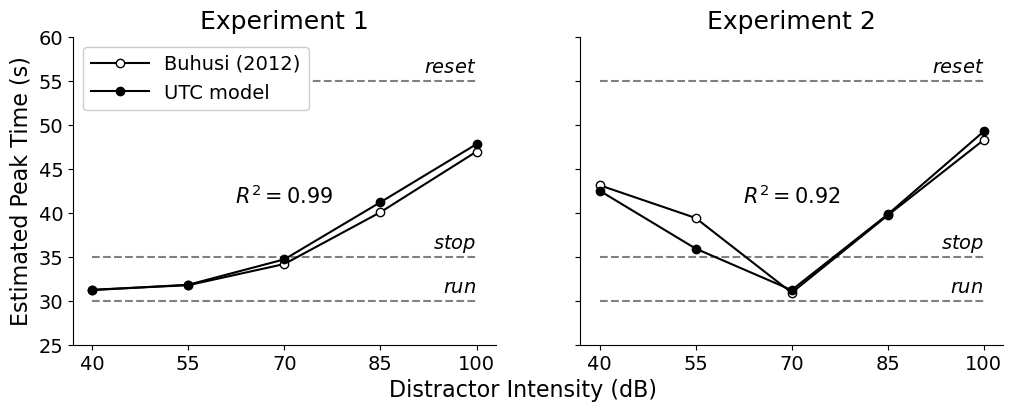

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), 
                               sharey=True, sharex=True)

# empirical data from Buhusi (2012)
peaks_empirical1 = np.array([31.27754915409236,
                             31.79606767261088,
                             34.203627495808554,
                             40.09221155311686,
                             46.981557689376544])

peaks_empirical2 = np.array([43.157894736842096,
                             39.4360902255639,
                             30.939849624060145,
                             39.73684210526315,
                             48.30827067669171])

ax1.set_ylim([25, 60])
ax1.set_yticks(np.arange(25, 65, 5))
ax1.set_ylabel('Estimated Peak Time (s)', fontsize=16)

ax1.set_xticks(np.linspace(40, 100, 5))
fig.text(0.5, -0.02, 'Distractor Intensity (dB)', 
         ha='center', fontsize=16)

ax1.tick_params(axis='both', labelsize=14)

ax1.hlines(y=30, xmin=40, xmax=100, ls='dashed', color='grey')
ax1.hlines(y=35, xmin=40, xmax=100, ls='dashed', color='grey')
ax1.hlines(y=55, xmin=40, xmax=100, ls='dashed', color='grey')

ax2.hlines(y=30, xmin=40, xmax=100, ls='dashed', color='grey')
ax2.hlines(y=35, xmin=40, xmax=100, ls='dashed', color='grey')
ax2.hlines(y=55, xmin=40, xmax=100, ls='dashed', color='grey')

# Empirical
ax1.plot(np.linspace(40, 100, 5), peaks_empirical1,
         color='black', marker='o', mfc='white',
         label='Buhusi (2012)')

ax2.plot(np.linspace(40, 100, 5), peaks_empirical2,
         color='black', marker='o', mfc='white',
         label='Buhusi (2012)')

# Model
ax1.plot(np.linspace(40, 100, 5), peaks1,
         color='black', marker='o', mfc='black',
         label='UTC model')

ax2.plot(np.linspace(40, 100, 5), peaks2,
         color='black', marker='o', mfc='black',
         label='UTC model')

ax1.set_title('Experiment 1', fontsize=18)
ax2.set_title('Experiment 2', fontsize=18)

ax1.text(100, 56, r'$\it{reset}$', ha='right')
ax1.text(100, 36, r'$\it{stop}$', ha='right')
ax1.text(100, 31, r'$\it{run}$', ha='right')

ax2.text(100, 56, r'$\it{reset}$', ha='right')
ax2.text(100, 36, r'$\it{stop}$', ha='right')
ax2.text(100, 31, r'$\it{run}$', ha='right')

ax1.text(x=70, y=42, size=15, ha='center', va='center',
         s=r'$R^2 = {:.2f}$'.format(round(r2_score(peaks_empirical1, peaks1), 2)))
ax2.text(x=70, y=42, size=15, ha='center', va='center',
         s=r'$R^2 = {:.2f}$'.format(round(r2_score(peaks_empirical2, peaks2), 2)))

ax1.legend(loc='upper left', framealpha=1.)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#axes.scatter(peaks)


#plt.savefig('buhusi2012_both.png', bbox_inches='tight', dpi=400)
#fig.savefig('buhusi2012_both.tiff', dpi=1000, bbox_inches='tight')

(28.75, 56.25, 28.75, 56.25)

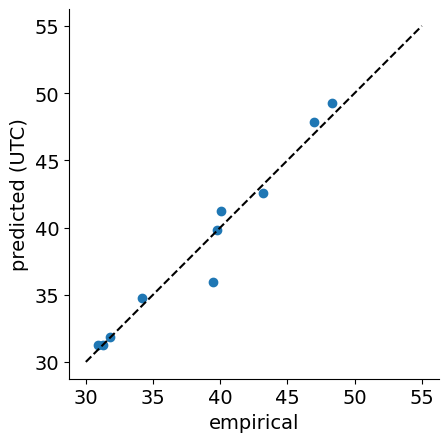

In [27]:
fig, ax = plt.subplots(1, 1)

ax.scatter(np.concatenate([peaks_empirical1,
                           peaks_empirical2]),
          np.concatenate([peaks1, peaks2]))
ax.set_xlim([0, 24])
ax.set_ylim([0, 24])
ax.plot([30, 55], [30, 55], color='black', ls='--')

ax.set_xlabel('empirical')
ax.set_ylabel('predicted (UTC)')

plt.axis('square')

### Cabeza de Vaca, Brown & Hemmes (1994) 'Internal Clock and Memory Processes in Animal Timing' (Experiment 2)

In [28]:
# set parameters
target = 28.9 # estimated peak time (from Cabeza de Vaca et al.)
dim = 2
gap_duration_list = np.array([3, 6, 9, 12, 15,   # duration (fixed onset)
                              6, 6, 6, 6,  6,    # location (fixed duration)
                              3, 6, 9, 12, 15,]) # duration (fixed end)

gap_start_list = np.array([6,  6,  6,  6,  6,     # duration (fixed onset)
                           3,  6,  9,  12, 15,    # location (fixed duration)
                           18, 15, 12, 9,  6])    # duration (fixed end)


def stimulus_function(t):
    return 0


vocab = spa.Vocabulary(64)
vocab.populate('T')

In [29]:
%%capture
if get_dat_method == 'simulate':
    # Baseline peak-interval trial
    UTC().run(task_type='gap_procedure',
                         direct_mode=True,
                         dimensions=dim,
                         base_theta=target,
                         effective_theta=target,
                         gap_duration=0,
                         stimulus_function=stimulus_function,
                         vocab=vocab,
                         full_output=False,
                         data_dir='cabeza_de_vaca_etal')

    # Gap trials
    for i in range(len(gap_duration_list)):
        UTC().run(task_type='gap_procedure',
                         direct_mode=True,
                         dimensions=dim,
                         base_theta=target,
                         effective_theta=target,
                         gap_start=gap_start_list[i],
                         gap_duration=gap_duration_list[i],
                         stimulus_function=stimulus_function,
                         vocab=vocab,
                         full_output=False,
                         data_dir='cabeza_de_vaca_etal')


In [30]:
gap_data = pytry.read('cabeza_de_vaca_etal')
gap_dt = pd.DataFrame(gap_data)

In [31]:
conditions = (gap_dt['gap_duration'] == 0.)
state_baseline = gap_dt[conditions]['x'].values[0]

# duration (fixed onset)
state_input_duration_onset = []
state_duration_onset = []
for i in range(0,5): 
    conditions = (gap_dt['gap_start']==gap_start_list[i]) & (gap_dt['gap_duration']==gap_duration_list[i]) 
    state_input_duration_onset.append(gap_dt[conditions]['state'].values[0])
    state_duration_onset.append(gap_dt[conditions]['x'].values[0])
    
# location (fixed duration)
state_input_location = []
state_location = []
for i in range(5,10): 
    conditions = (gap_dt['gap_start']==gap_start_list[i]) & (gap_dt['gap_duration']==gap_duration_list[i]) 
    state_input_location.append(gap_dt[conditions]['state'].values[0])
    state_location.append(gap_dt[conditions]['x'].values[0])
    
# duration (fixed offset)
state_input_duration_offset = []
state_duration_offset = []
for i in range(10,15): 
    conditions = (gap_dt['gap_start']==gap_start_list[i]) & (gap_dt['gap_duration']==gap_duration_list[i]) 
    state_input_duration_offset.append(gap_dt[conditions]['x'].values[0])
    state_duration_offset.append(gap_dt[conditions]['x'].values[0])


In [32]:
# get peak times
threshold = gap_dt['threshold'].values[0]
peak_baseline = np.where(state_baseline > threshold)[0][0]

peaks_duration_onset = []
peaks_location = []
peaks_duration_offset = []

for i in range(0, 5):
    # duration (fixed onset)
    temp = np.where(state_duration_onset[i] > threshold)[0][0] - peak_baseline
    peaks_duration_onset.append(temp/1000)
    
    # location (fixed duration)
    temp = np.where(state_location[i] > threshold)[0][0] - peak_baseline
    peaks_location.append(temp/1000)
    
    # duration (fixed offset)
    temp = np.where(state_duration_offset[i] > threshold)[0][0] - peak_baseline
    peaks_duration_offset.append(temp/1000)
    

/var/folders/tz/8tnj8bnd0gjcvxwkzlnskql00000gn/T/ipykernel_75868/1015278567.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


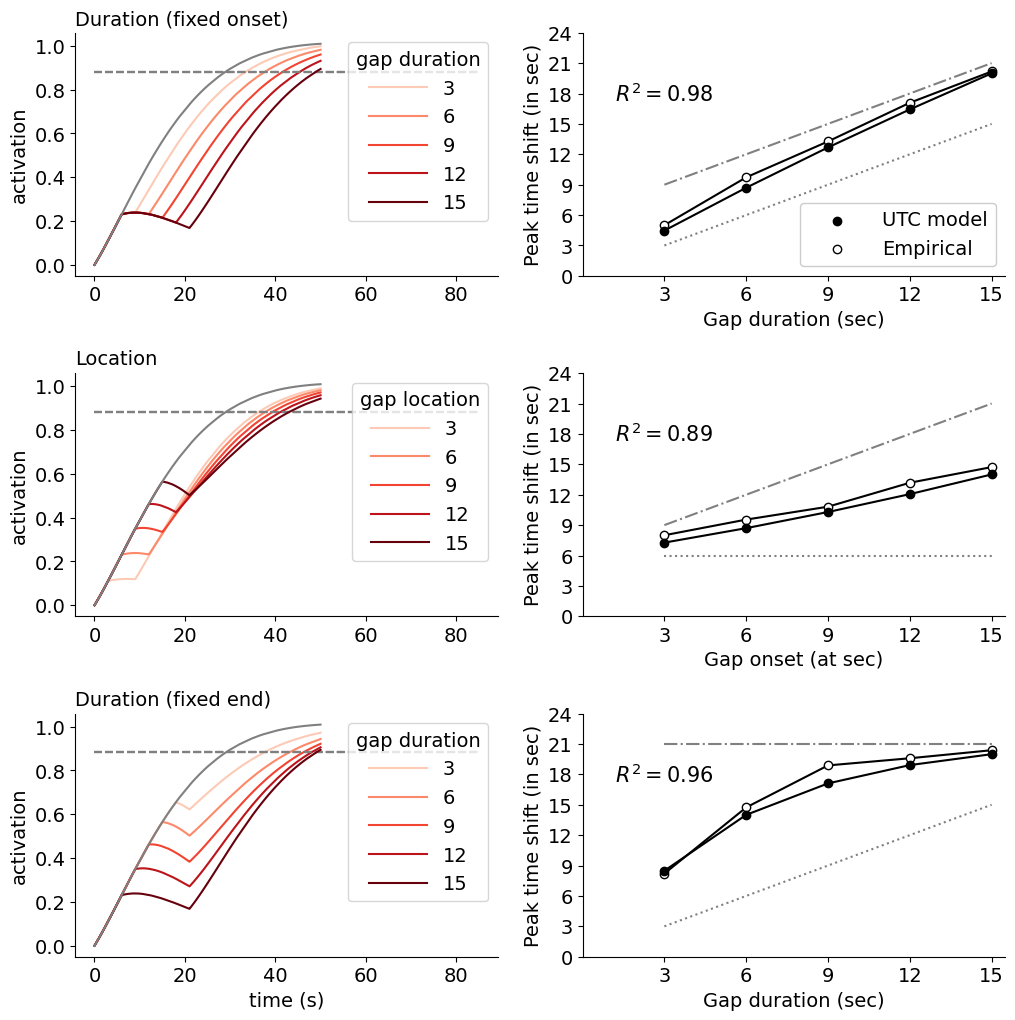

In [33]:
colors = plt.cm.Reds(np.linspace(0.2, 1, 5))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 12),
                                                        sharey=False, 
                                                        gridspec_kw={'hspace': 0.4})
plt.rcParams.update({'font.size': 14})
trange = np.arange(0.001, 50.001, 0.001)

for i in range(0, 5):
    
    # duration (fixed onset)
    ax1.hlines(y=threshold, xmin=0, xmax=85,
                  ls='dashed', color='grey')
    ax1.plot(trange,
                 state_duration_onset[i][:50000,0],
                 color=colors[i],
                 label='{}'.format(gap_duration_list[i]))
    
    # location (fixed duration)
    ax3.hlines(y=threshold, xmin=0, xmax=85,
                  ls='dashed', color='grey')
    ax3.plot(trange,
                 state_location[i][:50000,0],
                 color=colors[i],
                 label='{}'.format(gap_start_list[i+5]))
    
    # duration (fixed offset)
    ax5.hlines(y=threshold, xmin=0, xmax=85,
                  ls='dashed', color='grey')
    ax5.plot(trange,
                 state_duration_offset[i][:50000,0],
                 color=colors[i],
                 label='{}'.format(gap_duration_list[i+10]))

ax1.legend(title='gap duration')
ax3.legend(title='gap location')
ax5.legend(title='gap duration')
    
ax1.plot(trange, 
         state_baseline[:50000,0], color='grey')
ax3.plot(trange, 
         state_baseline[:50000,0], color='grey')
ax5.plot(trange, 
         state_baseline[:50000,0], color='grey')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.set_xlabel('time (s)')
ax1.set_ylabel('activation')
ax3.set_ylabel('activation')
ax5.set_ylabel('activation')
fig.tight_layout()

# Peak time plots --------
# duration (fixed onset)
peaks_duration_onset_empirical = np.array([4.998942917547566, 
                                    9.725158562367852,
                                    13.269556025369956,
                                    17.086680761099338,
                                    20.175475687103557])
ax2.set_ylim([0, 24])
ax2.set_xlim([0, 15.5])
ax2.set_yticks(np.arange(0, 27, 3))
ax2.set_xticks(np.arange(3, 18, 3))
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylabel('Peak time shift (in sec)')
ax2.set_xlabel('Gap duration (sec)')
ax1.set_title('Duration (fixed onset)', loc='left')
ax2.plot(gap_duration_list[0:5],
             peaks_duration_onset,
             color='black')
ax2.scatter(gap_duration_list[0:5],
                peaks_duration_onset,
                facecolors='black', edgecolors='black', zorder=11,
                label='UTC model')
ax2.plot(gap_duration_list[0:5],
             peaks_duration_onset_empirical,
             color='black')
ax2.scatter(gap_duration_list[0:5],
                peaks_duration_onset_empirical,
                facecolors='white', edgecolors='black', zorder=10,
                label='Empirical')
ax2.plot([3, 15], [3, 15], 
             ls='dotted', color='grey')
ax2.plot([3, 15], [9, 21], 
             ls='dashdot', color='grey')

ax2.text(x=3, y=18, size=15, ha='center', va='center',
         s=r'$R^2 = {:.2f}$'.format(round(r2_score(peaks_duration_onset_empirical, 
                                                   peaks_duration_onset), 2)))

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Location
peaks_location_empirical = np.array([7.999999999999986, 
                                    9.545454545454533,
                                    10.818181818181792,
                                    13.181818181818159,
                                    14.727272727272698])
ax4.set_ylim([0, 24])
ax4.set_xlim([0, 15.5])
ax4.set_yticks(np.arange(0, 27, 3))
ax4.set_xticks(np.arange(3, 18, 3))
ax4.xaxis.set_tick_params(labelbottom=True)
ax4.set_ylabel('Peak time shift (in sec)')
ax4.set_xlabel('Gap onset (at sec)')
ax3.set_title('Location', loc='left')
ax4.plot(gap_start_list[5:10],
             peaks_location,
             color='black')
ax4.scatter(gap_start_list[5:10],
                peaks_location,
                facecolors='black', edgecolors='black', zorder=11,
                label='UTC model')
ax4.plot(gap_start_list[5:10],
             peaks_location_empirical,
             color='black')
ax4.scatter(gap_start_list[5:10],
             peaks_location_empirical,
             facecolors='white', edgecolors='black', zorder=10,
             label='Empirical')
ax4.plot([3, 15], [6, 6], 
             ls='dotted', color='grey')
ax4.plot([3, 15], [9, 21], 
             ls='dashdot', color='grey')

ax4.text(x=3, y=18, size=15, ha='center', va='center',
         s=r'$R^2 = {:.2f}$'.format(round(r2_score(peaks_location_empirical, 
                                                   peaks_location), 2)))

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Duration offset fixed
peaks_duration_offset_empirical = np.array([8.205882352941174,
                                   14.735294117647044,
                                   18.88235294117645,
                                   19.588235294117624,
                                   20.382352941176464])
ax6.set_ylim([0, 24])
ax6.set_xlim([0, 15.5])
ax6.set_yticks(np.arange(0, 27, 3))
ax6.set_xticks(np.arange(3, 18, 3))
ax6.set_ylabel('Peak time shift (in sec)')
ax6.set_xlabel('Gap duration (sec)')
ax5.set_title('Duration (fixed end)', loc='left')
ax6.plot(gap_duration_list[10:15],
             peaks_duration_offset,
             color='black')
ax6.scatter(gap_duration_list[10:15],
                peaks_duration_offset,
                facecolors='black', edgecolors='black', zorder=11,
                label='UTC model')
ax6.plot(gap_duration_list[10:15],
             peaks_duration_offset_empirical,
             color='black')
ax6.scatter(gap_duration_list[10:15],
                peaks_duration_offset_empirical,
                facecolors='white', edgecolors='black', zorder=10,
                label='Empirical')
ax6.plot([3, 15], [3, 15], 
             ls='dotted', color='grey')
ax6.plot([3, 15], [21, 21], 
             ls='dashdot', color='grey')

ax6.text(x=3, y=18, size=15, ha='center', va='center',
         s=r'$R^2 = {:.2f}$'.format(round(r2_score(peaks_duration_offset_empirical, 
                                                   peaks_duration_offset), 2)))

ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

ax2.legend(loc='lower right', framealpha=1.)
#axes[1].legend(loc='upper left', fontsize=18, framealpha=1.)
#axes[2].legend(loc='upper left', fontsize=18, framealpha=1.)

plt.savefig('cabeza_de_vaca_trace.png', bbox_inches='tight', dpi=250)
fig.savefig('cabeza_de_vaca_trace.tiff', dpi=1000, bbox_inches='tight')


In [34]:
r2_score(np.concatenate([peaks_duration_onset_empirical,
                           peaks_location_empirical,
                           peaks_duration_offset_empirical]),
          np.concatenate([peaks_duration_onset,
                           peaks_location,
                           peaks_duration_offset]))

0.9712029106819183

(-1.2000000000000002, 25.2, -1.2000000000000002, 25.2)

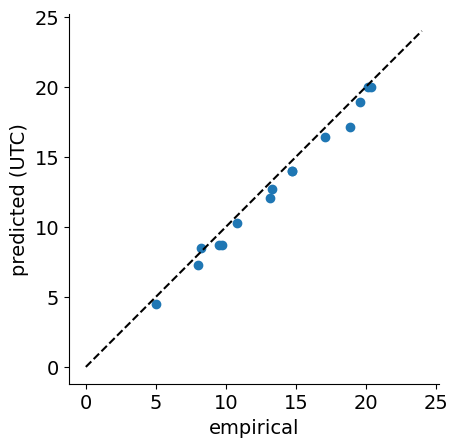

In [35]:
fig, ax = plt.subplots(1, 1)

ax.scatter(np.concatenate([peaks_duration_onset_empirical,
                           peaks_location_empirical,
                           peaks_duration_offset_empirical]),
          np.concatenate([peaks_duration_onset,
                           peaks_location,
                           peaks_duration_offset]))
ax.set_xlim([0, 24])
ax.set_ylim([0, 24])
ax.plot([0, 24], [0, 24], color='black', ls='--')

ax.set_xlabel('empirical')
ax.set_ylabel('predicted (UTC)')

plt.axis('square')